# Wright-Fisher model of mutation and random genetic drift

A Wright-Fisher model has a fixed population size N and discrete non-overlapping generations. Each generation, each individual has a random number of offspring whose mean is proportional to the individual's fitness. Each generation, mutation may occur.

Setup

In [8]:
import sys
!{sys.executable} -m pip install --upgrade pip

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: pytorch-lightning 1.5.9 has a non-standard dependency specifier torch>=1.7.*. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pytorch-lightning or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621


In [9]:
#!{sys.executable} -m pip install seaborn --upgrade
!{sys.executable} -m pip install matplotlib --upgrade
#!{sys.executable} -m pip install pandas --upgrade
#!{sys.executable} -m pip install numpy --upgrade

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 21.9 MB/s eta 0:00:0000:0100:01
DEPRECATION: pytorch-lightning 1.5.9 has a non-standard dependency specifier torch>=1.7.*. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pytorch-lightning or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.8.4
    Uninstalling matplotlib-3.8.4:
      Successfully uninstalled matplotlib-3.8.4
  DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no l

In [10]:
!{sys.executable} -m pip install ipywidgets==7.7.2 jupyterlab

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621


DEPRECATION: pytorch-lightning 1.5.9 has a non-standard dependency specifier torch>=1.7.*. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pytorch-lightning or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621


In [11]:
import numpy as np
import statistics as stat
import pandas as pd
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
import random
from itertools import *
try:
    import itertools.izip as zip
except ImportError:
    import itertools

/usr/local/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
Matplotlib is building the font cache; this may take a moment.


In [12]:
def flatten(listOfLists):
    "Flatten one level of nesting"
    return chain.from_iterable(listOfLists)


Make population dynamic model

Basic parameters

In [13]:
pop_size = 1000
seq_length = 1
alphabet = ['0','1']
base_haplotype = "0"


Setup a population of sequences

Store this as a lightweight Dictionary that maps a string to a count. All the sequences together will have count N.


In [14]:
pop = {}
pop["0"] = 100
pop["1"] = 900

Add mutation

Mutations occur each generation in each individual in every basepair.



In [15]:
mutation_rate = 0.0005 # per gen per individual per site

Walk through population and mutate basepairs.
Use Poisson splitting to speed this up (you may be familiar with Poisson splitting from its use in the Gillespie algorithm).

In naive scenario A: take each element and check for each if event occurs. For example, 100 elements, each with 1% chance. This requires 100 random numbers.
In Poisson splitting scenario B: Draw a Poisson random number for the number of events that occur and distribute them randomly. In the above example, this will most likely involve 1 random number draw to see how many events and then a few more draws to see which elements are hit.
First off, we need to get random number of total mutations


In [16]:
def get_mutation_count():
    mean = mutation_rate * pop_size * seq_length
    return np.random.poisson(mean)
#Here we use Numpy's Poisson random number.

get_mutation_count()

1

In [17]:
pop.keys()

dict_keys(['0', '1'])

In [18]:

[x/float(pop_size) for x in pop.values()]


[0.1, 0.9]

In [19]:
def get_random_haplotype():
    haplotypes = list(pop.keys())
    frequencies = [x/float(pop_size) for x in pop.values()]
    total = sum(frequencies)
    frequencies = [x / total for x in frequencies]
    return np.random.choice(haplotypes, p=frequencies)

get_random_haplotype()

'0'

Here, we take a supplied haplotype and mutate a site at random.


In [20]:
def get_mutant(haplotype):
    site = np.random.randint(seq_length)
    possible_mutations = list(alphabet)
    possible_mutations.remove(haplotype[site])
    mutation = np.random.choice(possible_mutations)
    new_haplotype = haplotype[:site] + mutation + haplotype[site+1:]
    return new_haplotype

get_mutant("0")


'1'

Putting things together, in a single mutation event, we grab a random haplotype from the population, mutate it, decrement its count, and then check if the mutant already exists in the population. If it does, increment this mutant haplotype; if it doesn't create a new haplotype of count 1.


In [21]:
def mutation_event():
    haplotype = get_random_haplotype()
    if pop[haplotype] > 1:
        pop[haplotype] -= 1
        new_haplotype = get_mutant(haplotype)
        if new_haplotype in pop:
            pop[new_haplotype] += 1
        else:
            pop[new_haplotype] = 1
mutation_event()
pop

{'0': 101, '1': 899}

To create all the mutations that occur in a single generation, we draw the total count of mutations and then iteratively add mutation events.


In [22]:
def mutation_step():
    mutation_count = get_mutation_count()
    for i in range(mutation_count):
        mutation_event()
mutation_step()
pop

{'0': 101, '1': 899}

## Genetic drift and selection

Selection and fitness are influenced by the game and payoff matrix

In [23]:
awm = x = 0.1
amw = y =  0.1
s=0

def get_fitness(awm, amw, s, frequencies):
    payoff=[[1, 1+awm], [1+s+amw, 1+s]]
    x = frequencies
    f = np.dot(payoff,x)
    fitness = {'0':f[0], '1':f[1]}
    return fitness

def get_offspring_counts(s,x,y):
    haplotypes = list(pop.keys())
    frequencies = [pop[haplotype]/float(pop_size) for haplotype in haplotypes]
    fitness = get_fitness(x,y,s,frequencies)
    fitnesses = [fitness[haplotype] for haplotype in haplotypes]
    weights = [x * y for x,y in zip(frequencies, fitnesses)]
    total = sum(weights)
    #print(fitness, weights, total)
    weights = [x / total for x in weights]
    if any(x<0 for x in weights):
        weights = [round(x) for x in weights]
    #print(weights)
    return list(np.random.multinomial(pop_size, weights))
#Here we use Numpy's multinomial random sample.

pop = {'0':500, '1':500}
haplotypes = list(pop.keys())
frequencies = [pop[haplotype]/float(pop_size) for haplotype in haplotypes]


get_offspring_counts(s,x,y)


[497, 503]


We then need to assign this new list of haplotype counts to the pop dictionary. To save memory and computation, if a haplotype goes to 0, we remove it entirely from the pop dictionary.


In [24]:
def offspring_step(s,x,y):
    haplotypes = list(pop.keys())
    counts = get_offspring_counts(s,x,y)
    for (haplotype, count) in zip(haplotypes, counts):
        if (count > 0):
            pop[haplotype] = count
        else:
            pop[haplotype] = 0
offspring_step(s,x,y)
pop

{'0': 505, '1': 495}

Combine and iterate

Each generation is simply a mutation step where a random number of mutations are thrown down, and an offspring step where haplotype counts are updated.


In [25]:
def time_step(s,x,y):
    mutation_step()
    offspring_step(s,x,y)

Can iterate this over a number of generations.


Record

We want to keep a record of past population frequencies to understand dynamics through time. At each step in the simulation, we append to a history object.


In [26]:
pop0 = {'0':500,'1':500}
history = []
generations = 1000


def simulate(s,x,y):
    history = []
    clone_pop = dict(pop)
    history.append(clone_pop)
    for i in range(generations):
        time_step(s,x,y)
        clone_pop = dict(pop)
        history.append(clone_pop)
    return(history)



List of game options

In [27]:
amw_list = [random.uniform(-0.3, 0.3) for i in range(100)]
awm_list = [random.uniform(-0.3, 0.3) for i in range(100)]

merged_list = [(amw_list[i], awm_list[i]) for i in range(0, len(amw_list))]
fixed_list = [(0.2, 0.2) for i in range(0,len(amw_list))]
coords = merged_list
x = [i[0] for i in coords]
y = [i[1] for i in coords]


# Masking, maintenance and mimicry



The following expressions are for non-zero μ

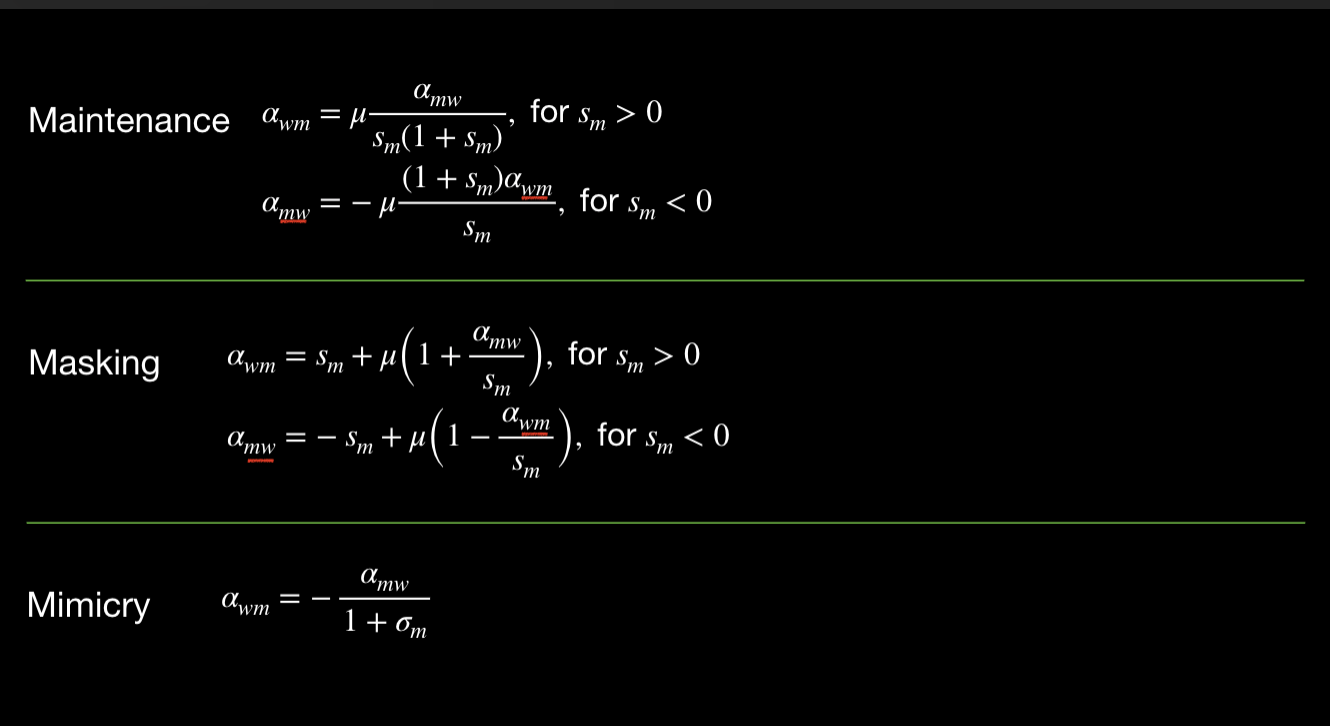

### Functions for maintenance, masking and mimicry

Small μ → 0

In [28]:
def maintain_0(awm, s):
    amw = awm = 0
    return(amw)

def mask_0(awm, s):
    amw = awm -2*s
    return(amw)

def mimic_0(awm, s):
    amw = -s/(1+s)
    return(amw)



μ^2 → 0

In [29]:
def theor_mode(s,mu):
    mode = (-2*mu + s + np.sqrt(4*mu**2 + s**2))/(2*s)
    return(mode)

def maintain_1(amw, s, mu):
    
    awm = mu*amw/(s*(1+s))
    
    return(awm)

def mask_1(amw, s, mu):
    if s>0:
        awm = 2*s + amw
    else:
        awm = -2*s + amw
        
    return(awm)

def mimic_1(amw, s, mu):
    awm = -s/(1+s) + (-s + amw)*mu/(s*(1+s))
    
    return(awm)

def mirror(s, mu, awm):
    amw = -2*s-(2*s-awm+s*awm)*mu/(s)
    #awm = s*(2+s)
    return(awm,amw)

In [30]:
def theor_mode(s,mu):
    mode = (-2*mu + s + np.sqrt(4*mu**2 + s**2))/(2*s)
    return(mode)

### Maintenance simulations
Maintenance is when the outcome (mode) of the simulation is kept the same

Original simulation, s=0.05, μ=0.005

In [31]:
from numpy.lib.function_base import kaiser
pop = {'0':500,'1':500}

#outcome = np.array([simulate(s,x,y) for x,y in merged_list ])
outcomes = []
histories = []
histories1 = []
s=0.1
sm=0
mutation_rate = 0.01
generations = gens = 1000
reps = 5

awm_vals = np.linspace(-0.15,0.15,6)
for m in [0.002,0.01]:
    for jj in awm_vals :
        history = []
        history1 = []
        print(jj)
        for i in range(1,reps+1):
            pop = {'0':500,'1':500}
            k = 0
            j = 0
            mutation_rate = m
            a = simulate(s,j,k)
            history1.append(stat.mode([ii['0'] for ii in a[(gens-101):(gens-1)]]))
            history.append(a)
        #print(s, j ,k )
        histories.append(history)
        histories1.append({'mu':m, 'a_wm':jj, 'mode':stat.mode(history1)})

#modes = bstat.mode(outcomes, axis=0)



-0.15
-0.09
-0.03
0.03
0.09
0.15
-0.15
-0.09
-0.03
0.03
0.09
0.15


In [32]:
np.savetxt('reps20_gens2000_s0.1_.out', histories1)

TypeError: Mismatch between array dtype ('object') and format specifier ('%.18e')

In [ ]:
histories[2]

In [ ]:
mode0, lower0, upper0 = [],[],[]
mode1, lower1, upper1 = [],[],[]

for t in range(0,gens):
    vals0 = []
    vals1=[]
    for si in range(0,reps):
        sli = histories[2][si][t]
        vals0.append(sli['0'])
        vals1.append(sli['1'])
    mode0.append(stat.mode(vals0))
    lower0.append(min(vals0))
    upper0.append(max(vals0))
    mode1.append(stat.mode(vals1))
    lower1.append(min(vals1))
    upper1.append(max(vals1))

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

len(mode0)
ax = sns.lineplot(x=[i for i in range(0,gens)], y=mode0, color='yellow')
ax.fill_between(
    [i for i in range(0,gens)], lower0, upper0, color='yellow', alpha=.15)
ax1 = sns.lineplot(x=[i for i in range(0,gens)], y=mode1, color='r')
ax1.fill_between(
    [i for i in range(0,gens)], lower1, upper1, color='r', alpha=.15)
ax.set_ylim(0,sum(pop.values()))


Maintenance

μ^2 →0 , interactions are non-zero

In [ ]:
from numpy.lib.function_base import kaiser
pop = {'0':500,'1':500}

#outcome = np.array([simulate(s,x,y) for x,y in merged_list ])
outcomes = []
histories = []
histories1 = []
s=0.1
sm=0
mutation_rate = mu = 0.01
generations = gens = 500
reps = 25

for jj in awm_vals :
    outcome = []
    history = []
    history1 = []
    print(jj)
    for i in range(1,reps+1):
        pop = {'0':500,'1':500}
        k = awm = jj
        j = maintain_1(amw=k, s=s, mu=mu)
        a = simulate(s,j,k)
        history1.append(stat.mode([ii['0'] for ii in a[(gens-101):(gens-1)]]))
        history.append(a)
        #print(s, j ,k )
    outcomes.append(outcome)
    histories.append(history)
    histories1.append(history1)

#modes = stat.mode(outcomes, axis=0)

#np.savetxt('s0.05a120.14_a210.16_games50_.out', (np.array(x), np.array(y), means))

In [ ]:
mode0, lower0, upper0 = [],[],[]
mode1, lower1, upper1 = [],[],[]

for t in range(0,gens):
    vals0 = []
    vals1=[]
    for si in range(0,reps):
        sli = histories[4][si][t]
        vals0.append(sli['0'])
        vals1.append(sli['1'])
    mode0.append(stat.mode(vals0))
    lower0.append(min(vals0))
    upper0.append(max(vals0))
    mode1.append(stat.mode(vals1))
    lower1.append(min(vals1))
    upper1.append(max(vals1))


len(mode0)
ax = sns.lineplot(x=[i for i in range(0,gens)], y=mode0, color='yellow')
ax.fill_between(
    [i for i in range(0,gens)], lower0, upper0, color='yellow', alpha=.15)
ax1 = sns.lineplot(x=[i for i in range(0,gens)], y=mode1, color='r')
ax1.fill_between(
    [i for i in range(0,gens)], lower1, upper1, color='r', alpha=.15)
ax.set_ylim(0,sum(pop.values()))

Masking

In masking the presence of interactions removes selective differences

In [ ]:
pop = {'0':500,'1':500}

#outcome = np.array([simulate(s,x,y) for x,y in merged_list ])
outcomes = []
histories = []
histories1 = []
s=0.1
sm=0
mutation_rate = mu = 0.001
generations = gens = 1500
reps = 50

for jj in awm_vals:
    outcome = []
    history = []
    history1=[]
    print(jj)
    for i in range(1,reps+1):
        pop = {'0':500,'1':500}
        k = awm = jj
        j = mask_0(awm=k, s=s)
        a = simulate(s,k,j)
        outcome.append(a[gens-1]['0'])
        history1.append([ii['0'] for ii in a])
        history.append(a)
        #print(s, j ,k )
    outcomes.append(outcome)
    histories1.append(flatten(history1))
    histories.append(history)


#np.savetxt('s0.05a120.14_a210.16_games50_.out', (np.array(x), np.array(y), means))

In [ ]:
mode_hist = [stat.mode(i) for i in histories1]
mode_hist

In [ ]:
mode0, lower0, upper0 = [],[],[]
mode1, lower1, upper1 = [],[],[]
gens = 900
for t in range(0,gens):
    vals0 = []
    vals1=[]
    for si in range(0,reps):
        sli = histories[4][si][t]
        vals0.append(sli['0'])
        vals1.append(sli['1'])
    mode0.append(stat.mode(vals0))
    lower0.append(min(vals0))
    upper0.append(max(vals0))
    mode1.append(stat.mode(vals1))
    lower1.append(min(vals1))
    upper1.append(max(vals1))


len(mode0)
ax = sns.lineplot(x=np.array([i for i in range(0,gens)]), y=mode0, color='yellow')
#ax.fill_between(
#    [i for i in range(0,gens)], lower0, upper0, color='yellow', alpha=.15)
ax1 = sns.lineplot(x=[i for i in range(0,gens)], y=mode1, color='r')
#ax1.fill_between(
#    [i for i in range(0,gens)], lower1, upper1, color='r', alpha=.15)
ax.set_ylim(0,sum(pop.values()))


First order μ

In [ ]:
pop = {'0':500,'1':500}

#outcome = np.array([simulate(s,x,y) for x,y in merged_list ])
outcomes = []
histories = []
histories1 = []

s=0.1
sm=0
mutation_rate = mu =0.01
generations = gens = 200
reps = 25

for jj in awm_vals:
    outcome = []
    history = []
    history1 = []
    print(jj)
    for i in range(1,reps+1):
        pop = {'0':500,'1':500}
        amw = jj
        awm = mask_1(amw=amw, s=s,mu=mu)
        a = simulate(s,awm,amw)
        history1.append([ii['0'] for ii in a])
        history.append(a)
        #print(s, j ,k )
    outcomes.append(outcome)
    histories1.append(flatten(history1))
    histories.append(history)



In [ ]:
mode_hist = [stat.mode(i) for i in histories1]
mode_hist

In [ ]:
mode0, lower0, upper0 = [],[],[]
mode1, lower1, upper1 = [],[],[]
#gens = 200
for t in range(0,gens):
    vals0 = []
    vals1=[]
    for si in range(0,reps):
        sli = histories[2][si][t]
        vals0.append(sli['0'])
        vals1.append(sli['1'])
    mode0.append(stat.mode(vals0))
    lower0.append(min(vals0))
    upper0.append(max(vals0))
    mode1.append(stat.mode(vals1))
    lower1.append(min(vals1))
    upper1.append(max(vals1))


len(mode0)
#listp=[i for i in range(0,gens)]
#df=pd.DataFrame({'x':listp, 'y':mode0})
#plt.plot(df['x'],df['y'])
ax = sns.lineplot(x=[i for i in range(0,gens)], y=mode0, color='yellow')
ax.fill_between(
    [i for i in range(0,gens)], lower0, upper0, color='yellow', alpha=.15)
ax1 = sns.lineplot(x=[i for i in range(0,gens)], y=mode1, color='r')
ax1.fill_between(
    [i for i in range(0,gens)], lower1, upper1, color='r', alpha=.15)
ax.set_ylim(0,sum(pop.values()))

Mimicry

In the absence of cell-intrinsic selection, interactions alone can cause selective pressures

In [ ]:
pop = {'0':500,'1':500}

#outcome = np.array([simulate(s,x,y) for x,y in merged_list ])
outcomes = []
histories = []
histories1 = []
s=0       # Intrinsic selection difference
sm=0.1    # Selection to mimic
mutation_rate = mu = 0.01
generations = gens = 900
reps = 25

for jj in awm_vals:
    outcome = []
    history = []
    history1=[]
    print(jj)
    for i in range(1,reps+1):
        pop = {'0':500,'1':500}
        amw = jj
        awm = mimic_0(amw, s=sm)
        a = simulate(s,awm,amw)
        history1.append([ii['0'] for ii in a])
        history.append(a)
        #print(s, j ,k )
    outcomes.append(outcome)
    histories1.append(flatten(history1))
    histories.append(history)


In [ ]:
mode_hist = [stat.mode(i) for i in histories1]
mode_hist

In [ ]:
mode0, lower0, upper0 = [],[],[]
mode1, lower1, upper1 = [],[],[]
gens = 900
for t in range(0,gens):
    vals0 = []
    vals1=[]
    for si in range(0,reps):
        sli = histories[4][si][t]
        vals0.append(sli['0'])
        vals1.append(sli['1'])
    mode0.append(stat.mode(vals0))
    lower0.append(min(vals0))
    upper0.append(max(vals0))
    mode1.append(stat.mode(vals1))
    lower1.append(min(vals1))
    upper1.append(max(vals1))


len(mode0)
ax = sns.lineplot(x=[i for i in range(0,gens)], y=mode0, color='yellow')
ax.fill_between(
    [i for i in range(0,gens)], lower0, upper0, color='yellow', alpha=.15)
ax1 = sns.lineplot(x=[i for i in range(0,gens)], y=mode1, color='r')
ax1.fill_between(
    [i for i in range(0,gens)], lower1, upper1, color='r', alpha=.15)
ax.set_ylim(0,sum(pop.values()))

Mimicry 1st order

In [ ]:
pop = {'0':500,'1':500}

#outcome = np.array([simulate(s,x,y) for x,y in merged_list ])
outcomes = []
histories = []
histories1 = []
s=0         # Intrinsic selection difference
sm=0.1      # Selection to mimic
mutation_rate = mu =0.01
generations = gens = 900
reps = 100

for jj in awm_vals:
    outcome = []
    history = []
    history1 =[]
    print(jj)
    for i in range(1,reps+1):
        pop = {'0':500,'1':500}
        amw = jj
        awm = mimic_1(amw, s=sm, mu=mu)
        a = simulate(s,awm,amw)
        history1.append([ii['0'] for ii in a])
        history.append(a)
        #print(s, j ,k )
    outcomes.append(outcome)      
    histories1.append(flatten(history1))
    histories.append(history)

In [ ]:
mode_hist = [stat.mode(i) for i in histories1]
mode_hist

In [ ]:
mode0, lower0, upper0 = [],[],[]
mode1, lower1, upper1 = [],[],[]
gens = 900
for t in range(0,gens):
    vals0 = []
    vals1=[]
    for si in range(0,reps):
        sli = histories[2][si][t]
        vals0.append(sli['0'])
        vals1.append(sli['1'])
    mode0.append(stat.mode(vals0))
    lower0.append(min(vals0))
    upper0.append(max(vals0))
    mode1.append(stat.mode(vals1))
    lower1.append(min(vals1))
    upper1.append(max(vals1))


len(mode0)
ax = sns.lineplot(x=[i for i in range(0,gens)], y=mode0, color='yellow')
ax.fill_between(
    [i for i in range(0,gens)], lower0, upper0, color='yellow', alpha=.15)
ax1 = sns.lineplot(x=[i for i in range(0,gens)], y=mode1, color='r')
ax1.fill_between(
    [i for i in range(0,gens)], lower1, upper1, color='r', alpha=.15)
ax.set_ylim(0,sum(pop.values()))

In [ ]:
#Closest Mirror
d_mirror=0.022143
A=1.0
B=0.9600
C=1.6000
D=1.0800

awm=B-A
amw=C-D

pop = {'0':500,'1':500}

#outcome = np.array([simulate(s,x,y) for x,y in merged_list ])
outcomes = []
histories = []
histories1 = []
s=D-A
sm=0.1      # Selection to mimic
mutation_rate = mu =0.001
generations = gens = 900
reps = 20

on_off = [(s,0,0), (s,awm,amw)]
for s,awm,amw in on_off:
    outcome = []
    history = []
    history1 =[]
    print((s,awm,amw))
    for i in range(1,reps+1):
        pop = {'0':500,'1':500}
        a = simulate(s,amw,awm)
        history1.append([ii['0'] for ii in a])
        history.append(a)
        #print(s, j ,k )
    outcomes.append(outcome)      
    histories1.append(flatten(history1))
    histories.append(history)

In [ ]:
#Plot mode of history 1
mode0, lower0, upper0 = [],[],[]
mode1, lower1, upper1 = [],[],[]
gens = 900
for t in range(0,gens):
    vals0 = []
    vals1=[]
    for si in range(0,reps):
        sli = histories[0][si][t]
        vals0.append(sli['0'])
        vals1.append(sli['1'])
    mode0.append(stat.mode(vals0))
    lower0.append(min(vals0))
    upper0.append(max(vals0))
    mode1.append(stat.mode(vals1))
    lower1.append(min(vals1))
    upper1.append(max(vals1))

len(mode0)

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

ax = sns.lineplot(x=[i for i in range(0,gens)], y=mode0, color='yellow', label="Type 1, no interactions")
ax.fill_between(
    [i for i in range(0,gens)], lower0, upper0, color='yellow', alpha=.15)
ax1 = sns.lineplot(x=[i for i in range(0,gens)], y=mode1, color='r',  label="Type 2, no interactions")
ax1.fill_between(
    [i for i in range(0,gens)], lower1, upper1, color='r', alpha=.15)
ax.set_ylim(0,sum(pop.values()))

#Plot mode of history 2

mode0, lower0, upper0 = [],[],[]
mode1, lower1, upper1 = [],[],[]
gens = 900
for t in range(0,gens):
    vals0 = []
    vals1=[]
    for si in range(0,reps):
        sli = histories[1][si][t]
        vals0.append(sli['0'])
        vals1.append(sli['1'])
    mode0.append(stat.mode(vals0))
    lower0.append(min(vals0))
    upper0.append(max(vals0))
    mode1.append(stat.mode(vals1))
    lower1.append(min(vals1))
    upper1.append(max(vals1))

len(mode0)

ax = sns.lineplot(x=[i for i in range(0,gens)], y=mode0, color='orange', label="Type 1 with eco-interactions")
ax.fill_between(
    [i for i in range(0,gens)], lower0, upper0, color='orange', alpha=.15)
ax1 = sns.lineplot(x=[i for i in range(0,gens)], y=mode1, color='b', label="Type 2 with eco-interactions")
ax1.fill_between(
    [i for i in range(0,gens)], lower1, upper1, color='b', alpha=.15)
ax.set_ylim(0,sum(pop.values()))

plt.legend(frameon=False)
ax.get_figure().savefig('mimic_literature.png', dpi=250)

In [ ]:
#Closest Maintenance
A=1.0
B=1.0077
C=0.9786
D=0.7545
d_mt_s=0.022143


awm=B-A
amw=C-D

pop = {'0':500,'1':500}

#outcome = np.array([simulate(s,x,y) for x,y in merged_list ])
outcomes = []
histories = []
histories1 = []
s=D-A
sm=0.1      # Selection to mimic
mutation_rate = mu =0.001
generations = gens = 900
reps = 20

on_off = [(s,0,0), (s,awm,amw)]
for s,awm,amw in on_off:
    outcome = []
    history = []
    history1 =[]
    print((s,awm,amw))
    for i in range(1,reps+1):
        pop = {'0':500,'1':500}
        a = simulate(s,amw,awm)
        history1.append([ii['0'] for ii in a])
        history.append(a)
        #print(s, j ,k )
    outcomes.append(outcome)      
    histories1.append(flatten(history1))
    histories.append(history)

In [ ]:
#Plot mode of history 1
mode0, lower0, upper0 = [],[],[]
mode1, lower1, upper1 = [],[],[]
gens = 900
for t in range(0,gens):
    vals0 = []
    vals1=[]
    for si in range(0,reps):
        sli = histories[0][si][t]
        vals0.append(sli['0'])
        vals1.append(sli['1'])
    mode0.append(stat.mode(vals0))
    lower0.append(min(vals0))
    upper0.append(max(vals0))
    mode1.append(stat.mode(vals1))
    lower1.append(min(vals1))
    upper1.append(max(vals1))

len(mode0)

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

ax = sns.lineplot(x=[i for i in range(0,gens)], y=mode0, color='yellow', label="Type 1, no interactions")
ax.fill_between(
    [i for i in range(0,gens)], lower0, upper0, color='yellow', alpha=.15)
ax1 = sns.lineplot(x=[i for i in range(0,gens)], y=mode1, color='r',  label="Type 2, no interactions")
ax1.fill_between(
    [i for i in range(0,gens)], lower1, upper1, color='r', alpha=.15)
ax.set_ylim(0,sum(pop.values()))

#Plot mode of history 2

mode0, lower0, upper0 = [],[],[]
mode1, lower1, upper1 = [],[],[]
gens = 900
for t in range(0,gens):
    vals0 = []
    vals1=[]
    for si in range(0,reps):
        sli = histories[1][si][t]
        vals0.append(sli['0'])
        vals1.append(sli['1'])
    mode0.append(stat.mode(vals0))
    lower0.append(min(vals0))
    upper0.append(max(vals0))
    mode1.append(stat.mode(vals1))
    lower1.append(min(vals1))
    upper1.append(max(vals1))

len(mode0)

ax = sns.lineplot(x=[i for i in range(0,gens)], y=mode0, color='orange', label="Type 1 with eco-interactions")
ax.fill_between(
    [i for i in range(0,gens)], lower0, upper0, color='orange', alpha=.15)
ax1 = sns.lineplot(x=[i for i in range(0,gens)], y=mode1, color='b', label="Type 2 with eco-interactions")
ax1.fill_between(
    [i for i in range(0,gens)], lower1, upper1, color='b', alpha=.15)
ax.set_ylim(0,sum(pop.values()))

plt.legend(frameon=False)
ax.get_figure().savefig('maintain_literature.png', dpi=250)

In [ ]:
#Closest Mask
A=1.0
B=1.3462
C=1.1923
D=1.1538
d_mt_s=0.0001

#1.0	1.3462	1.1923	1.1538
awm=B-A
amw=C-D

pop = {'0':500,'1':500}

#outcome = np.array([simulate(s,x,y) for x,y in merged_list ])
outcomes = []
histories = []
histories1 = []
s=D-A
sm=0.1      # Selection to mimic
mutation_rate = mu =0.001
generations = gens = 900
reps = 20

on_off = [(s,0,0), (s,awm,amw)]
for s,awm,amw in on_off:
    outcome = []
    history = []
    history1 =[]
    print((s,awm,amw))
    for i in range(1,reps+1):
        pop = {'0':500,'1':500}
        a = simulate(s,awm,amw)
        history1.append([ii['0'] for ii in a])
        history.append(a)
        #print(s, j ,k )
    outcomes.append(outcome)      
    histories1.append(flatten(history1))
    histories.append(history)

In [ ]:
#Plot mode of history 1
mode0, lower0, upper0 = [],[],[]
mode1, lower1, upper1 = [],[],[]
gens = 900
for t in range(0,gens):
    vals0 = []
    vals1=[]
    for si in range(0,reps):
        sli = histories[0][si][t]
        vals0.append(sli['0'])
        vals1.append(sli['1'])
    mode0.append(stat.mode(vals0))
    lower0.append(min(vals0))
    upper0.append(max(vals0))
    mode1.append(stat.mode(vals1))
    lower1.append(min(vals1))
    upper1.append(max(vals1))

len(mode0)

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

ax = sns.lineplot(x=[i for i in range(0,gens)], y=mode0, color='yellow', label="Type 1, no interactions")
ax.fill_between(
    [i for i in range(0,gens)], lower0, upper0, color='yellow', alpha=.15)
ax1 = sns.lineplot(x=[i for i in range(0,gens)], y=mode1, color='r',  label="Type 2, no interactions")
ax1.fill_between(
    [i for i in range(0,gens)], lower1, upper1, color='r', alpha=.15)
ax.set_ylim(0,sum(pop.values()))



#Plot mode of history 2

mode0, lower0, upper0 = [],[],[]
mode1, lower1, upper1 = [],[],[]
gens = 900
for t in range(0,gens):
    vals0 = []
    vals1=[]
    for si in range(0,reps):
        sli = histories[1][si][t]
        vals0.append(sli['0'])
        vals1.append(sli['1'])
    mode0.append(stat.mode(vals0))
    lower0.append(min(vals0))
    upper0.append(max(vals0))
    mode1.append(stat.mode(vals1))
    lower1.append(min(vals1))
    upper1.append(max(vals1))

len(mode0)

ax = sns.lineplot(x=[i for i in range(0,gens)], y=mode0, color='orange', label="Type 1 with eco-interactions")
ax.fill_between(
    [i for i in range(0,gens)], lower0, upper0, color='orange', alpha=.15)
ax1 = sns.lineplot(x=[i for i in range(0,gens)], y=mode1, color='b', label="Type 2 with eco-interactions")
ax1.fill_between(
    [i for i in range(0,gens)], lower1, upper1, color='b', alpha=.15)
ax.set_ylim(0,sum(pop.values()))
plt.legend(frameon=False)
ax.get_figure().savefig('masking_literature.png', dpi=250)


Summary plotting for manuscript

1. Plot amw as function of awm (x3 cases)
2. Plot different lines for s 
3. Plot different lines for mu


In [ ]:
awm_vals = np.linspace(-0.15,0.15,10)
s_vals = np.linspace(0,1,10)
mu_vals = np.linspace(0.001, 0.1, 10)

In [ ]:
mask_df = pd.DataFrame({'amw':awm_vals,
                        'amw_s005_mu005':mask_1(awm_vals, 0.05, 0.005),
                        'amw_s01_mu005':mask_1(awm_vals, 0.1, 0.005),
                        'amw_s015_mu005':mask_1(awm_vals, 0.2, 0.005),
                        'amw_s005_mu05':mask_1(awm_vals, 0.05, 0.05),
                        'amw_s01_mu05':mask_1(awm_vals, 0.1, 0.05),
                        'amw_s015_mu05':mask_1(awm_vals, 0.2, 0.05),
                        'amw_s005_mu5':mask_1(awm_vals, 0.05, 0.5),
                        'amw_s01_mu5':mask_1(awm_vals, 0.1, 0.5),
                        'amw_s015_mu5':mask_1(awm_vals, 0.2, 0.5)
                       })

In [ ]:
fig, axes = plt.subplots(1, 2)



mask_df.plot(x='amw',y='amw_s005_mu005', ax=axes[0]) 
mask_df.plot(x='amw',y='amw_s01_mu005', ax=axes[0])
mask_df.plot(x='amw',y='amw_s015_mu005', ax=axes[0])

mask_df.plot(x='amw',y='amw_s005_mu05', ax=axes[1])
mask_df.plot(x='amw',y='amw_s01_mu05', ax=axes[1])
mask_df.plot(x='amw',y='amw_s015_mu05', ax=axes[1])

#mask_df.plot(x='awm',y='amw_s005_mu5', ax=axes[2])
#mask_df.plot(x='awm',y='amw_s01_mu5', ax=axes[2])
#mask_df.plot(x='awm',y='amw_s015_mu5', ax=axes[2])

axes[0].get_legend().remove()
axes[1].get_legend().remove()

axes[0].set(xlabel='', ylabel=r'$\alpha_{wm}$', title=r"$\mu$ = 0.005")
axes[1].set(xlabel=r'$\alpha_{mw}$', ylabel='', title=r"$\mu$ = 0.05")
#axes[2].set(xlabel='', ylabel='', title='0.5')

plt.legend(labels=["0.05", "0.1", "0.2"], title=r"$s_m$", frameon=False)
plt.legend().remove()
plt.gcf().set_size_inches(3.2, 2.5)
plt.savefig("mask_mu_plotno_leg.png",dpi=250)

In [ ]:
mimic_df = pd.DataFrame({'awm':awm_vals,
                        'amw_s005_mu005':mimic_1(awm_vals, 0.05, 0.005),
                        'amw_s01_mu005':mimic_1(awm_vals, 0.1, 0.005),
                        'amw_s015_mu005':mimic_1(awm_vals, 0.15, 0.005),
                        'amw_s005_mu05':mimic_1(awm_vals, 0.05, 0.05),
                        'amw_s01_mu05':mimic_1(awm_vals, 0.1, 0.05),
                        'amw_s015_mu05':mimic_1(awm_vals, 0.15, 0.05),
                        'amw_s005_mu5':mimic_1(awm_vals, 0.05, 0.5),
                        'amw_s01_mu5':mimic_1(awm_vals, 0.1, 0.5),
                        'amw_s015_mu5':mimic_1(awm_vals, 0.15, 0.5)
                       })

In [ ]:
mimic_df.dtypes

In [ ]:
#plt.figure(figsize=(0.5,1))
fig,axes = plt.subplots(1, 2)

mimic_df.plot( x='awm',y='amw_s005_mu005', ax=axes[0],figsize=(3.2,2.5))
mimic_df.plot(x='awm',y='amw_s01_mu005', ax=axes[0])
mimic_df.plot(x='awm',y='amw_s015_mu005', ax=axes[0])

mimic_df.plot(x='awm',y='amw_s005_mu05', ax=axes[1])
mimic_df.plot(x='awm',y='amw_s01_mu05', ax=axes[1])
mimic_df.plot(x='awm',y='amw_s015_mu05', ax=axes[1])

#sns.scatterplot(data =mimic_df,x='awm',y='amw_s005_mu5', ax=axes[2])
#sns.scatterplot(data =mimic_df,x='awm',y='amw_s01_mu5', ax=axes[2])
#sns.scatterplot(data =mimic_df,x='awm',y='amw_s015_mu5', ax=axes[2])

axes[0].get_legend().remove()

axes[1].get_legend().remove()

axes[0].set(xlabel='amw', ylabel='awm', title="mu = 0.005")
plt.title('')
axes[1].set(xlabel='amw', ylabel='', title="mu=0.05")
#axes[2].set(xlabel='', ylabel='', title='0.5')
plt.title('')
plt.legend(labels=["0.005", "0.01", "0.015"], title="s")

plt.savefig("mimic_mu_plot.png", dpi=300)

In [ ]:
print(sns.__version__)

In [ ]:
fig, axes = plt.subplots(1, 3)

sns.lineplot(data =mimic_df,x='awm',y='amw_s005_mu005', ax=axes[0])
sns.lineplot(data =mimic_df,x='awm',y='amw_s005_mu05', ax=axes[0])
sns.lineplot(data =mimic_df,x='awm',y='amw_s005_mu5', ax=axes[0])

sns.lineplot(data =mimic_df,x='awm',y='amw_s01_mu005', ax=axes[1])
sns.lineplot(data =mimic_df,x='awm',y='amw_s01_mu05', ax=axes[1])
sns.lineplot(data =mimic_df,x='awm',y='amw_s01_mu5', ax=axes[1])


sns.lineplot(data =mimic_df,x='awm',y='amw_s015_mu005', ax=axes[2])
sns.lineplot(data =mimic_df,x='awm',y='amw_s015_mu05', ax=axes[2])
sns.lineplot(data =mimic_df,x='awm',y='amw_s015_mu5', ax=axes[2])

axes[0].set(xlabel='', ylabel='amw', title="s = 0.005")
axes[1].set(xlabel='awm', ylabel='', title="0.05")
axes[2].set(xlabel='', ylabel='', title='0.5')
plt.gcf().set_size_inches(3.2, 2.5)
plt.legend(labels=["0.005", "0.05", "0.5"], title="mu")


In [ ]:
mirror_df = pd.DataFrame({'amw':awm_vals,
                        'amw_s005_mu005':mirror(0.005, 0.005,awm_vals)[1],
                        'amw_s01_mu005':mirror(0.01, 0.005,awm_vals)[1],
                        'amw_s015_mu005':mirror(0.015, 0.005,awm_vals)[1],
                        'amw_s005_mu05':mirror(0.005, 0.05,awm_vals)[1],
                        'amw_s01_mu05':mirror(0.01, 0.05,awm_vals)[1],
                        'amw_s015_mu05':mirror(0.015, 0.05,awm_vals)[1],
                        'amw_s005_mu5':mirror(0.005, 0.5,awm_vals)[1],
                        'amw_s01_mu5':mirror(0.01, 0.5,awm_vals)[1],
                        'amw_s015_mu5':mirror(0.015, 0.5,awm_vals)[1]
                       })

In [ ]:
fig, axes = plt.subplots(1, 2)


mirror_df.plot(x='amw',y='amw_s005_mu005', ax=axes[0])
mirror_df.plot(x='amw',y='amw_s01_mu005', ax=axes[0])
mirror_df.plot(x='amw',y='amw_s015_mu005', ax=axes[0])

mirror_df.plot(x='amw',y='amw_s005_mu05', ax=axes[1])
mirror_df.plot(x='amw',y='amw_s01_mu05', ax=axes[1])
mirror_df.plot(x='amw',y='amw_s015_mu05', ax=axes[1])

#sns.lineplot(data =maintain_df,x='awm',y='amw_s005_mu5', ax=axes[2])
#sns.lineplot(data =maintain_df,x='awm',y='amw_s01_mu5', ax=axes[2])
#sns.lineplot(data =maintain_df,x='awm',y='amw_s015_mu5', ax=axes[2])

axes[0].get_legend().remove()
axes[1].get_legend().remove()

axes[0].set(xlabel='', ylabel='awm', title="mu = 0.005")
axes[1].set(xlabel='amw', ylabel='', title="mu = 0.05")
#axes[2].set(xlabel='', ylabel='', title='0.5')

plt.legend(labels=["0.005", "0.01", "0.015"], title="s")
plt.gcf().set_size_inches(3.2, 2.5)
plt.savefig("mirror_mu_plot.png", dpi=250)

In [ ]:
maintain_df = pd.DataFrame({'amw':awm_vals,
                        'amw_s005_mu005':maintain_1(awm_vals, 0.05, 0.005),
                        'amw_s01_mu005':maintain_1(awm_vals, 0.1, 0.005),
                        'amw_s015_mu005':maintain_1(awm_vals, 0.2, 0.005),
                        'amw_s005_mu05':maintain_1(awm_vals, 0.05, 0.05),
                        'amw_s01_mu05':maintain_1(awm_vals, 0.1, 0.05),
                        'amw_s015_mu05':maintain_1(awm_vals, 0.2, 0.05),
                        'amw_s005_mu5':maintain_1(awm_vals, 0.05, 0.5),
                        'amw_s01_mu5':maintain_1(awm_vals, 0.1, 0.5),
                        'amw_s015_mu5':maintain_1(awm_vals, 0.2, 0.5)
                       })

In [ ]:
fig, axes = plt.subplots(1, 2)

maintain_df.plot(x='amw',y='amw_s005_mu005', ax=axes[0])
maintain_df.plot(x='amw',y='amw_s01_mu005', ax=axes[0])
maintain_df.plot(x='amw',y='amw_s015_mu005', ax=axes[0])

maintain_df.plot(x='amw',y='amw_s005_mu05', ax=axes[1])
maintain_df.plot(x='amw',y='amw_s01_mu05', ax=axes[1])
maintain_df.plot(x='amw',y='amw_s015_mu05', ax=axes[1])

#sns.lineplot(data =maintain_df,x='awm',y='amw_s005_mu5', ax=axes[2])
#sns.lineplot(data =maintain_df,x='awm',y='amw_s01_mu5', ax=axes[2])
#sns.lineplot(data =maintain_df,x='awm',y='amw_s015_mu5', ax=axes[2])

axes[0].get_legend().remove()
axes[1].get_legend().remove()

axes[0].set(xlabel='', ylabel='awm', title="mu = 0.005")
axes[1].set(xlabel='amw', ylabel='', title="mu = 0.05")
#axes[2].set(xlabel='', ylabel='', title='0.5')

plt.legend(labels=["0.05", "0.1", "0.2"], title="s")
plt.gcf().set_size_inches(3.2, 2.5)
plt.savefig("maintain_mu_plot.png", dpi=300)

Error in masking etc?

In [ ]:
df = pd.DataFrame()                                                                                                                                                                     

#Masking 
for alph in []:
    for s in []:
        for mu in []:
            
            result = simulate(s, mu)
            mode = mode(result)
            var = variance(result)
            mode_th = theor_mode(s, mu)
            error = result - mode_th
            df.append(alph, mu, s,mode, var, error)

In [ ]:
import pandas as pd

In [ ]:
df = pd.DataFrame({"awm":[], "amw":[], "type":[], "mu":[],"s":[],"mode":[],"var":[],"mean":[], "mode_th":[]})   
#Mimic
for alph in [0,0.01,0.05,0.1]:#,-0.02,0,0.02,0.04,0.08,0.1]:
    for sp in [0.05,0.1,0.2]:#,0.02,0.04,0.1]:
        for mu in [0.005,0.01]:#,0.01,0.02,0.05,0.1]:
            for rep in range(0,50):
                pop0 = {'0':500,'1':500}
                history = []
                generations = 4000
                mutation_rate=mu
                amw = alph
                if amw==0:
                    awm=0
                    result = simulate(0, awm, amw)
                else:
                    awm = mimic_1(amw, sp, mu)
                    result = simulate(0, awm, amw)
                x0 = [ii['0'] for ii in result]
            
                mode = stat.mode(x0[1000:generations])
                var = stat.stdev(x0[1000:generations])
                mean = np.mean(x0[1000:generations])
                mode_th = theor_mode(sp, mu)
                df2 = pd.DataFrame({"awm":[awm], "amw":[amw], "type":["mimic"], "mu":[mu],"s":[sp],"mode":[mode],"var":[var], "mean":[mean], "mode_th":[mode_th]})
                df = pd.concat([df, df2])
                
df.to_csv("final_sims_mimic.csv",index=False)

In [ ]:
df = pd.DataFrame({"awm":[], "amw":[], "type":[], "mu":[],"s":[],"mode":[],"var":[],"mean":[], "mode_th":[]})   
#Maintain
for alph in [0,0.01,0.05,0.1]:#,-0.02,0,0.02,0.04,0.08,0.1]:
    for s in [0.05,0.1,0.2]:#,0.02,0.04,0.1]:
        for mu in [0.005,0.01]:#,0.01,0.02,0.05,0.1]:
            for rep in range(0,50):
                pop0 = {'0':500,'1':500}
                history = []
                generations = 4000
                mutation_rate=mu
                amw=alph
                if amw==0:
                    awm=0
                else:
                    awm = maintain_1(amw, s, mu)
                result = simulate(s, awm, amw)
                x0 = [ii['0'] for ii in result]
            
                mode = stat.mode(x0[1000:generations])
                var = stat.stdev(x0[1000:generations])
                mean = np.mean(x0[1000:generations])
                mode_th = theor_mode(s, mu)
                
                df2 = pd.DataFrame({"awm":[awm], "amw":[amw], "type":["maintain"], "mu":[mu],"s":[s],"mode":[mode],"var":[var], "mean":[mean], "mode_th":[mode_th]})
                df = pd.concat([df, df2])
                
df.to_csv("final_sims_maintain2.csv",index=False)

In [ ]:
df = pd.DataFrame({"awm":[], "amw":[], "type":[], "mu":[],"s":[],"mode":[],"var":[],"mean":[], "mode_th":[]})   
#Mask
for alph in [0,0.01,0.05,0.1]:#,-0.02,0,0.02,0.04,0.08,0.1]:
    for sp in [0.05,0.1,0.2]:#,0.02,0.04,0.1]:
        for mu in [0.005,0.01]:#,0.01,0.02,0.05,0.1]:
            for rep in range(0,50):
                pop0 = {'0':500,'1':500}
                history = []
                generations = 4000
                mutation_rate=mu
                amw = alph
                if amw==0:
                    awm =0
                else:
                    awm = mask_1(amw, sp, mu)
                result = simulate(sp, awm, amw)
                x0 = [ii['0'] for ii in result]
            
                mode = stat.mode(x0[1000:generations])
                var = stat.stdev(x0[1000:generations])
                mean = np.mean(x0[1000:generations])
                mode_th = theor_mode(sp, mu)
                df2 = pd.DataFrame({"awm":[awm], "amw":[amw], "type":["mask"], "mu":[mu],"s":[sp],"mode":[mode],"var":[var], "mean":[mean], "mode_th":[mode_th]})
                df = pd.concat([df, df2])
df.to_csv("final_sims_mask.csv",index=False)

In [ ]:
df = pd.DataFrame({"awm":[], "amw":[], "type":[], "mu":[],"s":[],"mode":[],"var":[],"mean":[], "mode_th":[]})   
#Mirror
for alph in [0.01,0.05,0.1,0]:#,-0.02,0,0.02,0.04,0.08,0.1]:
    for sp in [0.05,0.1,0.2]:#,0.02,0.04,0.1]:
        for mu in [0.005,0.01]:#,0.01,0.02,0.05,0.1]:
            for rep in range(0,20):
                if (rep==5):
                    print(rep)
                pop0 = {'0':500,'1':500}
                history = []
                generations = 2000
                mutation_rate=mu
                awm = alph
                if awm==0:
                    amw=0
                else:
                    awm,amw = mirror(sp, mu, awm)
                    print(sp, mu, awm, amw)
                result = simulate(sp, awm, amw)
                x0 = [ii['0'] for ii in result]  
                mode = stat.mode(x0[1000:generations])
                var = stat.stdev(x0[1000:generations])
                mean = np.mean(x0[1000:generations])
                mode_th = theor_mode(sp, mu)
                df2 = pd.DataFrame({"awm":[awm], "amw":[amw], "type":["mirror"], "mu":[mu],"s":[sp],"mode":[mode],"var":[var], "mean":[mean], "mode_th":[mode_th]})
                df = pd.concat([df, df2])
df.to_csv("final_sims_mirror.csv",index=False)

In [ ]:
mask_df = pd.read_csv("final_sims_mask.csv")
maintain_df = pd.read_csv("final_sims_maintain2.csv")
mimic_df = pd.read_csv("final_sims_mimic.csv")
mirror_df =  pd.read_csv("final_sims_mirror.csv")

In [ ]:
mirror_df['amw']=np.round(mirror_df['amw'],4)

## Masking 
Plot successful

In [ ]:
mask_df.amw.unique()

In [ ]:
my_pal= ["r","b","b","b"]

g = sns.FacetGrid(data=mask_df, col="mu", row="s",size=3, aspect=1.2)
g.map_dataframe(sns.violinplot, "amw", "mean", palette=my_pal)
axes = flatten(g.axes)
for i in axes:
    i.axhline(y=500, ls="--")

g.savefig("mask_plot.png")

In [ ]:
g = sns.catplot(x="amw", y="mean", hue="s",row="mu", kind="box", data=mask_df, aspect=1.2)
axes = flatten(g.axes)

mus = [0.005,0.01]
j=0
pal = ["navy","orange","green"]

for i in axes:
    jj = 0
    plt.ylabel('')
    i.axhline(y=500, ls="--", color="purple")
    for sp in [0.05,0.1,0.2]:
        i.axhline(y=(1-theor_mode(s=sp,mu=mus[j]))*1000, ls="--", color=pal[jj])
        jj+=1
        plt.ylabel('')
    j=j+1
    
g.legend.remove()
plt.title('')
plt.ylabel('')
plt.xlabel('')
plt.gcf().set_size_inches(1.75, 3)

g.savefig("mask_plot2.png",  dpi=150)

### Mirroring

In [ ]:
import importlib
importlib.reload(sns)
sns.__version__

In [ ]:
mirror_df

In [ ]:


g = sns.catplot(x="awm", y="mean", hue="s",row="mu", kind="box", data=mirror_df, aspect=1.2)

axes = flatten(g.axes)
mus = [0.005,0.01]
j=0
pal = ["navy","orange","green"]

for i in axes:
    jj = 0
    i.axhline(y=500, ls="--", color="purple")
    for sp in [0.05,0.1,0.2]:
        i.axhline(y=(theor_mode(s=-sp,mu=mus[j]))*1000, ls="--", color="gray")
        i.axhline(y=(1-theor_mode(s=-sp,mu=mus[j]))*1000, ls="--", color=pal[jj])
        jj+=1
    j=j+1
g.legend.remove()
plt.title('')
plt.gcf().set_size_inches(1.75, 3)
g.savefig("mirror_plot.png", dpi=150)

## Maintenance
- update line

In [ ]:
my_pal= ["r","b","b","b"]

g = sns.FacetGrid(data=maintain_df, col="mu", row="s")
g.map_dataframe(sns.violinplot, "amw", "mean", palette=my_pal)
axes = flatten(g.axes)
par = [[0.05,0.005],[0.05,0.01],[0.1,0.005],[0.1,0.01],[0.2,0.005],[0.2,0.01]]

j = 0
for i in axes:
    i.axhline(y=(1-theor_mode(s=par[j][0],mu=par[j][1]))*1000, ls="--")
    j=j+1


In [ ]:
g = sns.catplot(x="amw",y="mean",hue="s",row="mu", data=maintain_df, kind="box", aspect=1.2)
axes = flatten(g.axes)
mus = [0.005,0.01]
j=0
pal = ["navy","orange","green"]

for i in axes:
    jj = 0
    #i.axhline(y=500, ls="--", color="purple")

    for sp in [0.05,0.1,0.2]:
        i.axhline(y=(1-theor_mode(s=sp,mu=mus[j]))*1000, ls="--", color=pal[jj])
        jj+=1
    j=j+1
    
g.legend.remove()
plt.title('')
plt.gcf().set_size_inches(1.75, 3)
g.savefig("maintain_plot2.png", dpi=150)

## Mimicry 
- see plot
- add lines


In [ ]:
#g = sns.FacetGrid(tips, col="time",  row="sex")
#g.map(sns.scatterplot, "total_bill", "tip")

par = [[0.05,0.005],[0.05,0.01],[0.1,0.005],[0.1,0.01],[0.2,0.005],[0.2,0.01]]

g = sns.FacetGrid(data=mimic_df, col="mu", row="s", aspect=1.2)
g.map_dataframe(sns.violinplot, "amw", "mean", palette=my_pal)
axes = flatten(g.axes)

g.add_legend({"no interaction":"r"})
j=0
for i in axes:
    i.axhline(y=(1-theor_mode(s=par[j][0],mu=par[j][1]))*1000, ls="--")
    j=j+1
g.legend.remove()
plt.title('')
plt.gcf().set_size_inches(1.75, 3)
g.savefig("mimic_plot.png", dpi=150)

In [ ]:
g = sns.catplot(x="amw",y="mean",hue="s",row="mu", data=mimic_df, kind="box", aspect=1.2)
axes = flatten(g.axes)
mus = [0.005,0.01]
j=0
pal = ["navy","orange","green"]

for i in axes:
    i.axhline(y=500, ls="--", color="purple")
    jj = 0
    for sp in [0.05,0.1,0.2]:
        i.axhline(y=(1-theor_mode(s=sp,mu=mus[j]))*1000, ls="--", color=pal[jj])
        jj+=1
    j=j+1
    
g.legend.remove()
plt.title('')
plt.gcf().set_size_inches(1.75, 3)
g.savefig("mimic_plot2.png", dpi=150)

In [ ]:
flatten_comprehension([["0.01"]*5, ["0.05"]*5,["0.1"]*5])

In [ ]:
 def flatten_comprehension(matrix):
        return [item for row in matrix for item in row]

Appendix 

-
-


---


In [ ]:
j, k
x0 = [i['0'] for i in a]
x1 = [i['1'] for i in a]
df = pd.DataFrame({'x0':x0, 'x1':x1})
sns.lineplot(data=df[['x0', 'x1']], sort=False)


In [ ]:
from itertools import chain


def flatten(listOfLists):
    "Flatten one level of nesting"
    return chain.from_iterable(listOfLists)

list(flatten(outcomes))

In [ ]:
out = list(flatten(outcomes))
graph = sns.scatterplot(x=np.linspace(1,len(out), len(out)), y=out, linewidth=0)
graph.axhline(0, c="black")
graph.axvline(0,  c="black")
graph.axhline(-s, c="black", linestyle='--')
graph.axvline(s,  c="black", linestyle='--')
graph.legend('')
N= sum(pop.values())
mu= mutation_rate
print('s'+str(s)+'N'+str(N)+'mu'+str(mu))


In [ ]:
len(out)

In [ ]:
graph =sns.histplot(x=[i/1000 for i in out], kde=True)
#graph.axhline(0, c="black")
plt.xlim(0,1)
#graph.axhline(-s, c="black", linestyle='--')
#graph.axvline(s,  c="black", linestyle='--')
graph.legend('')
N= sum(pop.values())
mu= mutation_rate
print('s'+str(s)+'N'+str(N)+'mu'+str(mu))




plt.show()

In [ ]:
outcomes

### Plot selection function
Sigma

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
import pandas as pd
%matplotlib inline

In [ ]:
def sigma_mu(a_mw,a_wm):
    sigma = (2*s**2 + s*(a_mw-a_wm) + (2*mu-np.sqrt(4*mu**2+s**2))*(a_mw+a_wm))/(2*s+(s-2*mu+np.sqrt(4*mu**2+s**2))*a_wm)
    return(sigma)

In [ ]:
a_mw = np.linspace(0.001,0.5,1000)
a_wm = a_mw
s = 0.1
mu = 0.001 
list_all = product(a_mw, a_wm)
list_ = [(i,j) for (i,j) in list_all]
list_all = np.swapaxes(list_,0,1)
out_all = sigma_mu(list_all[0],list_all[1])

for i in range(0,len(out_all)):
    if round(out_all[i],3)==0.100:
        print(list_all[0][i],list_all[1][i])

In [ ]:
plotting = pd.DataFrame({'a_mw':list_all[0], 'a_wm':list_all[1], 'val':out_all})

In [ ]:
fig, ax = plt.subplots()

matrix = np.array(out_all).reshape(1000, 1000)
plt.imshow(matrix[1:20][1:20])